## Lab 3: Знайомство з нейромережами

##### завдання 1
1. Повнозв'язані нейронні мережі
Візьміть дані, з якими ви працювали в лабораторній №1.  Побудуйте повнозв’язану нейронну мережу
прямого поширення () для задачі класифікації.
Навчіть її на тренувальній вибірці, протестуйте на тестовій. Порівняйте результати з алгоритмами з Lab 1.

In [3]:
# ================================
# 1️⃣ Повнозв'язана нейронна мережа (MLP) для класифікації відтоку
# ================================
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# --- 1. Завантаження даних ---
df = pd.read_csv('spotify_churn_dataset.csv')
target_col = "is_churned"

# видаляємо параметр, який слугує ідентифікатором
df.drop("user_id", axis=1, inplace=True)

num_features = ["age", "listening_time", "songs_played_per_day", "ads_listened_per_week"]
print("Data describe:")
cm = sns.light_palette("blue", as_cmap=True)
display(df[num_features].describe().T.style.background_gradient(cmap=cm))

# перевірка на дублікати
def check_duplicates_report(df, dataset_name):
    duplicates_count = df.duplicated().sum()
    total_rows = len(df)
    
    print(f"🔍 {dataset_name} Аналіз дублікатів")
    
    if duplicates_count == 0:
        print(f"✅ Дублікатів не знайдемо серед {total_rows:,} записів")
    else:
        print(f"⚠️  {duplicates_count} duplicates found ({duplicates_count/total_rows:.2%})")
        print(f"    Total rows affected: {duplicates_count:,}/{total_rows:,}")

datasets = {
    "Data": df
}

duplicate_summary = {}
for name, data in datasets.items():
    check_duplicates_report(data, name)
    duplicate_summary[name] = {
        "duplicates": data.duplicated().sum(),
        "total_rows": len(data)
    }
    
# 1. One-Hot Encoding для gender, subscription_type, device_type
one_hot_cols = ['gender', 'subscription_type', 'device_type']
df_one_hot = pd.get_dummies(df[one_hot_cols], drop_first=True)

# 2. Frequency Encoding для country
freq_encoding = df['country'].value_counts(normalize=True)  # частка появи
df['country_freq'] = df['country'].map(freq_encoding)

df_encoded = pd.concat([df.drop(columns=one_hot_cols + ['country']), df_one_hot], axis=1)

# Тепер df_encoded
print("Після кодування:")
df_encoded.head()

# Створюємо копію df_encoded, щоб не зіпсувати оригінал
df = df_encoded.copy()

# 1. Standard Scaling для age та songs_played_per_day
scaler_std = StandardScaler()
df[['age_scaled', 'songs_played_scaled']] = scaler_std.fit_transform(df[['age', 'songs_played_per_day']])
df.drop(columns=['age', 'songs_played_per_day'], inplace=True)  # видаляємо оригінальну колонку

# 2. MinMax Scaling для listening_time
scaler_mm = MinMaxScaler()
df['listening_time_scaled'] = scaler_mm.fit_transform(df[['listening_time']])
df.drop(columns=['listening_time'], inplace=True)  # видаляємо оригінальну колонку

# 3. Log + MinMax для ads_listened_per_week
df['ads_log_scaled'] = np.log1p(df['ads_listened_per_week'])
df['ads_scaled'] = scaler_mm.fit_transform(df[['ads_log_scaled']])
df.drop(columns=['ads_listened_per_week', 'ads_log_scaled'], inplace=True)

df.head()

2025-11-01 11:06:59.818418: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data describe:


,count,mean,std,min,25%,50%,75%,max
age,8000.000000,37.662125,12.740359,16.000000,26.000000,38.000000,49.000000,59.000000
listening_time,8000.000000,154.068250,84.015596,10.000000,81.000000,154.000000,227.000000,299.000000
songs_played_per_day,8000.000000,50.127250,28.449762,1.000000,25.000000,50.000000,75.000000,99.000000
ads_listened_per_week,8000.000000,6.943875,13.617953,0.000000,0.000000,0.000000,5.000000,49.000000


🔍 Data Аналіз дублікатів
✅ Дублікатів не знайдемо серед 8,000 записів
Після кодування:


,skip_rate,offline_listening,is_churned,country_freq,gender_Male,gender_Other,subscription_type_Free,subscription_type_Premium,subscription_type_Student,device_type_Mobile,device_type_Web,age_scaled,songs_played_scaled,listening_time_scaled,ads_scaled
0,0.20,0,1,0.119250,False,False,True,False,False,False,False,1.282452,-0.953574,0.055363,0.885919
1,0.34,1,0,0.126875,False,True,False,False,False,False,True,-0.365956,0.417349,0.453287,0.000000
2,0.04,1,1,0.129250,True,False,False,True,False,True,False,0.026522,-0.426296,0.653979,0.000000
3,0.31,1,0,0.119250,False,False,False,False,True,True,False,-1.229408,-1.691763,0.089965,0.000000
4,0.36,1,1,0.129000,False,True,False,False,False,True,False,-0.679939,0.241590,0.830450,0.000000


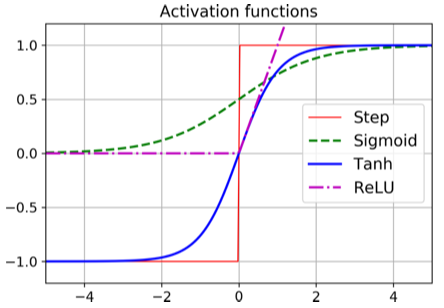

In [15]:
from sklearn.utils import class_weight

target_col = "is_churned"
X = df.drop(columns=[target_col])
y = df[target_col]

# --- 2. Масштабування ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 3. Розбиття на train/test ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# --- 4. Побудова MLP ---
mlp_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# --- 5. Навчання ---
history_mlp = mlp_model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, class_weight=class_weights_dict)

# --- 6. Оцінка ---
y_pred_mlp = (mlp_model.predict(X_test) > 0.5).astype(int)

print("========== MLP RESULTS ==========")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print(classification_report(y_test, y_pred_mlp))

Epoch 1/50


/Users/bohdanr/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5137 - loss: 0.7339 - val_accuracy: 0.5578 - val_loss: 0.6850
Epoch 2/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5181 - loss: 0.7060 - val_accuracy: 0.4523 - val_loss: 0.7045
Epoch 3/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5036 - loss: 0.6950 - val_accuracy: 0.4711 - val_loss: 0.6997
Epoch 4/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5036 - loss: 0.6948 - val_accuracy: 0.5297 - val_loss: 0.6907
Epoch 5/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5168 - loss: 0.6933 - val_accuracy: 0.5008 - val_loss: 0.6926
Epoch 6/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5209 - loss: 0.6936 - val_accuracy: 0.4984 - val_loss: 0.6945
Epoch 7/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5266 - loss: 0.6887 - val_accuracy: 0.5078 - val_loss: 0.6939
Epoch 8/50
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5215 - loss: 0.6944 - val_accuracy: 0.5469 - val_

# завдання 2:
2. Згорткові нейронні мережі
- а) Побудуйте просту згорткову нейронну мережу (2–3 convolutional шари + fully connected). Навчіть її на обраному вами датасеті.
  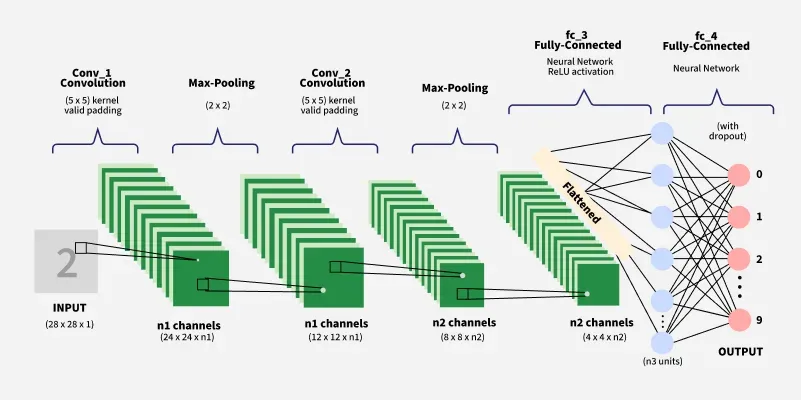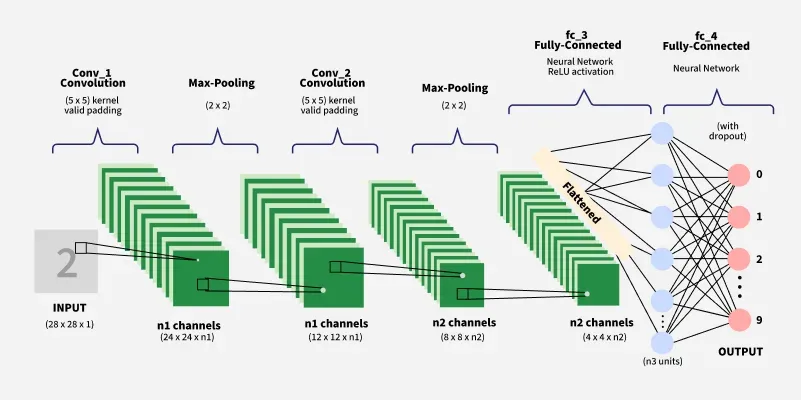

      CNN (Convolutional Neural Network) — це тип штучної нейронної мережі, призначений для обробки структурованих даних із топологією решітки, таких як зображення (2D-матриці пікселів).
        
        🔹 Основна ідея:
            Замість того, щоб обробляти зображення як «плоский» вектор, CNN використовує згорткові операції (convolutions), щоб виявляти локальні шаблони:
            на перших шарах — прості (краї, кути), на глибших — складніші (форми, частини об’єктів), у кінці — семантичні ознаки (наприклад, “кіт”, “машина” тощо).
        
        🔹 Основні компоненти:
                Convolutional Layer (згортковий шар):
                    - Основний будівельний блок CNN.
                    - Кожен фільтр (kernel) проходить по зображенню і формує карту ознак (feature map).
                    - Фільтри навчаються автоматично.
            
                Activation Function (ReLU):
                    - Застосовується після згортки для нелінійності.
                    - Допомагає моделі навчати складні зв’язки.
        
                Pooling Layer (підвибірка): Зменшує розмірність карти ознак, зберігаючи найважливішу інформацію.
                Fully Connected Layer (щільний шар): З’єднує всі ознаки у вектор і приймає рішення (наприклад, який клас зображення).
                Output Layer: Наприклад, Softmax — видає ймовірності приналежності до класів.
        
        🔹 Особливості CNN:
              - Локальність зв’язків: кожен нейрон бачить лише частину зображення;
              - Спільне використання ваг: один фільтр застосовується по всьому зображенню → менше параметрів;
              - Ієрархічність ознак: від простих до складних рівнів;
              - Висока точність у задачах комп’ютерного зору (класифікація, детекція, сегментація).
- б) Використайте попередньо натреновану архітектуру (наприклад, ResNet, VGG, MobileNet). Замініть вихідний класифікатор на новий під ваші класи. Проведіть донавчання () моделі на вашому датасеті. Порівняйте результати (точність, швидкість збіжності, кількость даних).

In [8]:
# ================================
# 2️⃣ Згорткова нейронна мережа (CNN)
# ================================
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten

# Використаємо CIFAR10 як приклад
(X_cnn, y_cnn), (X_cnn_test, y_cnn_test) = cifar10.load_data()
y_cnn_cat = to_categorical(y_cnn, 10)
y_cnn_test_cat = to_categorical(y_cnn_test, 10)
X_cnn = X_cnn.astype('float32') / 255.0
X_cnn_test = X_cnn_test.astype('float32') / 255.0

# --- CNN модель ---
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=X_cnn.shape[1:]),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.fit(X_cnn, y_cnn_cat, validation_split=0.2, epochs=10, batch_size=64)

cnn_eval = cnn_model.evaluate(X_cnn_test, y_cnn_test_cat)
print("========== CNN RESULTS ==========")
print("Test accuracy:", cnn_eval[1])

/Users/bohdanr/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.3095 - loss: 1.8622 - val_accuracy: 0.5102 - val_loss: 1.3659
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 30s 47ms/step - accuracy: 0.5295 - loss: 1.3036 - val_accuracy: 0.5687 - val_loss: 1.2278
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 52ms/step - accuracy: 0.6013 - loss: 1.1215 - val_accuracy: 0.6261 - val_loss: 1.0633
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.6528 - loss: 0.9853 - val_accuracy: 0.6385 - val_loss: 1.0471
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - accuracy: 0.6866 - loss: 0.8935 - val_accuracy: 0.6755 - val_loss: 0.9422
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 32s 50ms/step - accuracy: 0.7117 - loss: 0.8193 - val_accuracy: 0.6836 - val_loss: 0.9209
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.7358 - loss: 0.7555 - val_accuracy: 0.6936 - val_loss: 0.8878
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 49ms/step - accuracy: 0.7537 - loss: 0.6987 - 

    🧩 CIFAR-10 — це класичний датасет зображень для навчання нейромереж

    Повна назва: Canadian Institute for Advanced Research — 10 classes
    Розроблений: у Канадському інституті передових досліджень (CIFAR).
    Формат: набір маленьких кольорових зображень для задач класифікації.

    📸 Характеристики CIFAR-10
    Властивість	Значення
    📦 Кількість зображень	60 000
    🧠 Навчальна вибірка	50 000
    🧪 Тестова вибірка	10 000
    🎨 Розмір зображення	32×32 пікселі
    🌈 Кольори	RGB (3 канали)
    🏷️ Кількість класів	10
  
    🧠 Класи CIFAR-10
        ✈️ airplane — літаки
        🚗 automobile — автомобілі
        🐦 bird — птахи
        🐱 cat — коти
        🦌 deer — олені
        🐶 dog — собаки
        🐸 frog — жаби
        🐴 horse — коні
        🚢 ship — кораблі
        🚚 truck — вантажівки

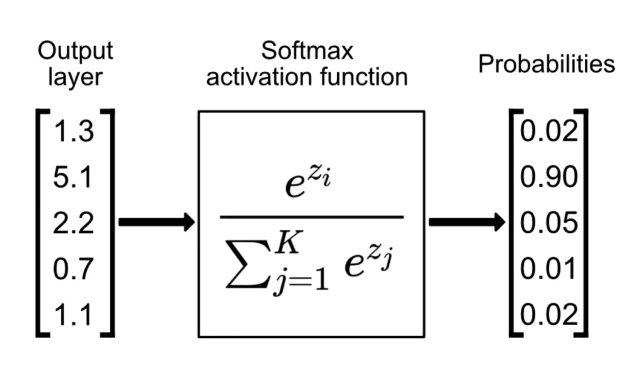

In [9]:
# ================================
# 2️⃣ Згорткова нейронна мережа (CNN) - pretrained (ResNet50)
# ================================
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

# --- 1. Дані CIFAR-10 ---
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# --- 2. Завантаження pretrained ResNet50 ---
# include_top=False => без останнього класифікатора
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Заморожуємо шари базової моделі на початку
for layer in base_model.layers:
    layer.trainable = False

# --- 3. Додавання нового класифікатора ---
x = base_model.output
x = GlobalAveragePooling2D()(x)  # скорочує розмірність feature maps
x = Dense(256, activation='relu')(x)
output = Dense(10, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=output)

# --- 4. Компільовання ---
resnet_model.compile(optimizer=Adam(learning_rate=1e-3),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# --- 5. Навчання (fine-tuning) ---
history_resnet = resnet_model.fit(X_train, y_train_cat,
                                  validation_split=0.2,
                                  epochs=10,
                                  batch_size=64)

# --- 6. Оцінка ---
resnet_eval = resnet_model.evaluate(X_test, y_test_cat)
print("========== Pretrained ResNet50 RESULTS ==========")
print("Test accuracy:", resnet_eval[1])


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 124s 185ms/step - accuracy: 0.2001 - loss: 2.2249 - val_accuracy: 0.2882 - val_loss: 1.9348
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 200ms/step - accuracy: 0.3028 - loss: 1.9255 - val_accuracy: 0.3032 - val_loss: 1.9299
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 245ms/step - accuracy: 0.3217 - loss: 1.8616 - val_accuracy: 0.3249 - val_loss: 1.8791
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 241ms/step - accuracy: 0.3382 - loss: 1.8291 - val_accuracy: 0.3647 - val_loss: 1.7673
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 243ms/step - accuracy: 0.3534 - loss: 1.7889 - val_accuracy: 0.3539 - val_loss: 1.7763
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 215s 264ms/step - accuracy: 0.3564 - loss: 1.7699 - val_accuracy: 0.3799 - val_loss: 1.7482
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 231ms/step - accuracy: 0.3705 - loss: 1.7492 - val_accuracy: 0.3908 - val_loss: 1.7114
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 160s 256ms/step - accuracy: 0.3752 -

#### Завдання 3

3.  Вирішіть задачу класифікації текстів (використайте той же
датасет, з яким ви працювали в лабораторній № 2) двома способами:

        а) Побудуйте модель з вбудованим Embedding шаром (ініціалізованим випадковими вагами). Використайте RNN / LSTM / GRU для класифікації. Навчіть модель на вашому датасеті.
        б) Завантажте готові embeddings (наприклад, GloVe). Ініціалізуйте Embedding шар цими вагами.
        Проведіть навчання.
        Порівняйте якість класифікації у (а) та (б). Чи покращилися метрики при використанні pretrained embeddings? Наскільки швидше/стабільніше відбулося навчання?

In [10]:
# ================================
# 3️⃣ Класифікація текстів (LSTM) на прикладі 20 Newsgroups
# ================================
from sklearn.datasets import fetch_20newsgroups
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM

# --- Завантажуємо дані ---
cats = ['comp.graphics', 'sci.space', 'rec.sport.baseball']
data = fetch_20newsgroups(subset='train', categories=cats, remove=('headers','footers','quotes'))
texts = data.data
labels = data.target
num_classes = len(cats)

# --- Передобробка ---
import re
texts_clean = [re.sub(r'[^a-z\s]', '', t.lower()) for t in texts]

# --- Токенізація ---
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_clean)
sequences = tokenizer.texts_to_sequences(texts_clean)
X_seq = pad_sequences(sequences, maxlen=100)
y_seq = tf.keras.utils.to_categorical(labels, num_classes)

# --- Розбиття ---
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# --- LSTM з випадковими embedding ---
lstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=50, input_length=100),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_seq, y_train_seq, validation_split=0.2, epochs=10, batch_size=32)

eval_lstm = lstm_model.evaluate(X_test_seq, y_test_seq)
print("========== LSTM RANDOM EMBEDDINGS ==========")
print("Test accuracy:", eval_lstm[1])

Epoch 1/10


/Users/bohdanr/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


36/36 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - accuracy: 0.3942 - loss: 1.0938 - val_accuracy: 0.5106 - val_loss: 1.0434
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.6134 - loss: 0.9347 - val_accuracy: 0.5775 - val_loss: 0.8344
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.7967 - loss: 0.5800 - val_accuracy: 0.7958 - val_loss: 0.6496
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9058 - loss: 0.3147 - val_accuracy: 0.8204 - val_loss: 0.4731
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9393 - loss: 0.2377 - val_accuracy: 0.8063 - val_loss: 0.6149
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.9135 - loss: 0.2601 - val_accuracy: 0.7958 - val_loss: 0.5047
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - accuracy: 0.9520 - loss: 0.1619 - val_accuracy: 0.8415 - val_loss: 0.3712
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.9667 - loss: 0.0994 - val_accuracy: 0.8345 - val_loss: 0.

In [22]:
# ============================================
# 🧠 LSTM з GloVe embeddings для класифікації текстів
# ============================================
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_20newsgroups
import gensim.downloader as api
import re

# --- 1️⃣ Завантаження текстових даних ---
cats = ['comp.graphics', 'sci.space', 'rec.sport.baseball']
data = fetch_20newsgroups(subset='train', categories=cats, remove=('headers','footers','quotes'))
texts = data.data
labels = data.target
num_classes = len(cats)

# --- 2️⃣ Передобробка тексту ---
texts_clean = [re.sub(r'[^a-z\s]', '', t.lower()) for t in texts]

# --- 3️⃣ Токенізація ---
max_words = 5000
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts_clean)
sequences = tokenizer.texts_to_sequences(texts_clean)
X_seq = pad_sequences(sequences, maxlen=100)
y_seq = tf.keras.utils.to_categorical(labels, num_classes)

# --- 4️⃣ Розбиття на train/test ---
X_train_seq, X_test_seq, y_train_seq, y_test_seq = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# --- 5️⃣ Завантаження попередньо навчених GloVe embeddings ---
print("🔽 Завантаження GloVe (це може зайняти трохи часу)...")
glove_model = api.load("glove-wiki-gigaword-50")  # 50-вимірна версія

# --- 6️⃣ Створення embedding-матриці ---
embedding_dim = 50
word_index = tokenizer.word_index
num_tokens = min(max_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_tokens, embedding_dim))

for word, i in word_index.items():
    if i >= max_words:
        continue
    if word in glove_model:
        embedding_matrix[i] = glove_model[word]

# --- 7️⃣ Побудова моделі LSTM ---
lstm_glove = Sequential([
    Embedding(num_tokens, embedding_dim, weights=[embedding_matrix], input_length=100, trainable=False),
    LSTM(64),
    Dense(num_classes, activation='softmax')
])
lstm_glove.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_glove.summary()

# --- 8️⃣ Навчання моделі ---
history = lstm_glove.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=10,
    batch_size=32,
    verbose=1
)

# --- 9️⃣ Оцінка ---
eval_glove = lstm_glove.evaluate(X_test_seq, y_test_seq)
print("========== ✅ LSTM + GloVe EMBEDDINGS ==========")
print(f"Test accuracy: {eval_glove[1]:.4f}")

🔽 Завантаження GloVe (це може зайняти трохи часу)...
[==================================================] 100.0% 66.0/66.0MB downloaded


/Users/bohdanr/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,000 (976.56 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 250,000 (976.56 KB)

Epoch 1/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.4362 - loss: 1.0490 - val_accuracy: 0.6972 - val_loss: 0.7275
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.7432 - loss: 0.6315 - val_accuracy: 0.7570 - val_loss: 0.6000
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7593 - loss: 0.6022 - val_accuracy: 0.8310 - val_loss: 0.4815
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.8358 - loss: 0.4348 - val_accuracy: 0.8275 - val_loss: 0.4126
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.8548 - loss: 0.3634 - val_accuracy: 0.8239 - val_loss: 0.4458
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8332 - loss: 0.4171 - val_accuracy: 0.8556 - val_loss: 0.4104
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8306 - loss: 0.4285 - val_accuracy: 0.8415 - val_loss: 0.4106
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8754 - loss: 0.3250 - val_accuracy: 0.8380 - v

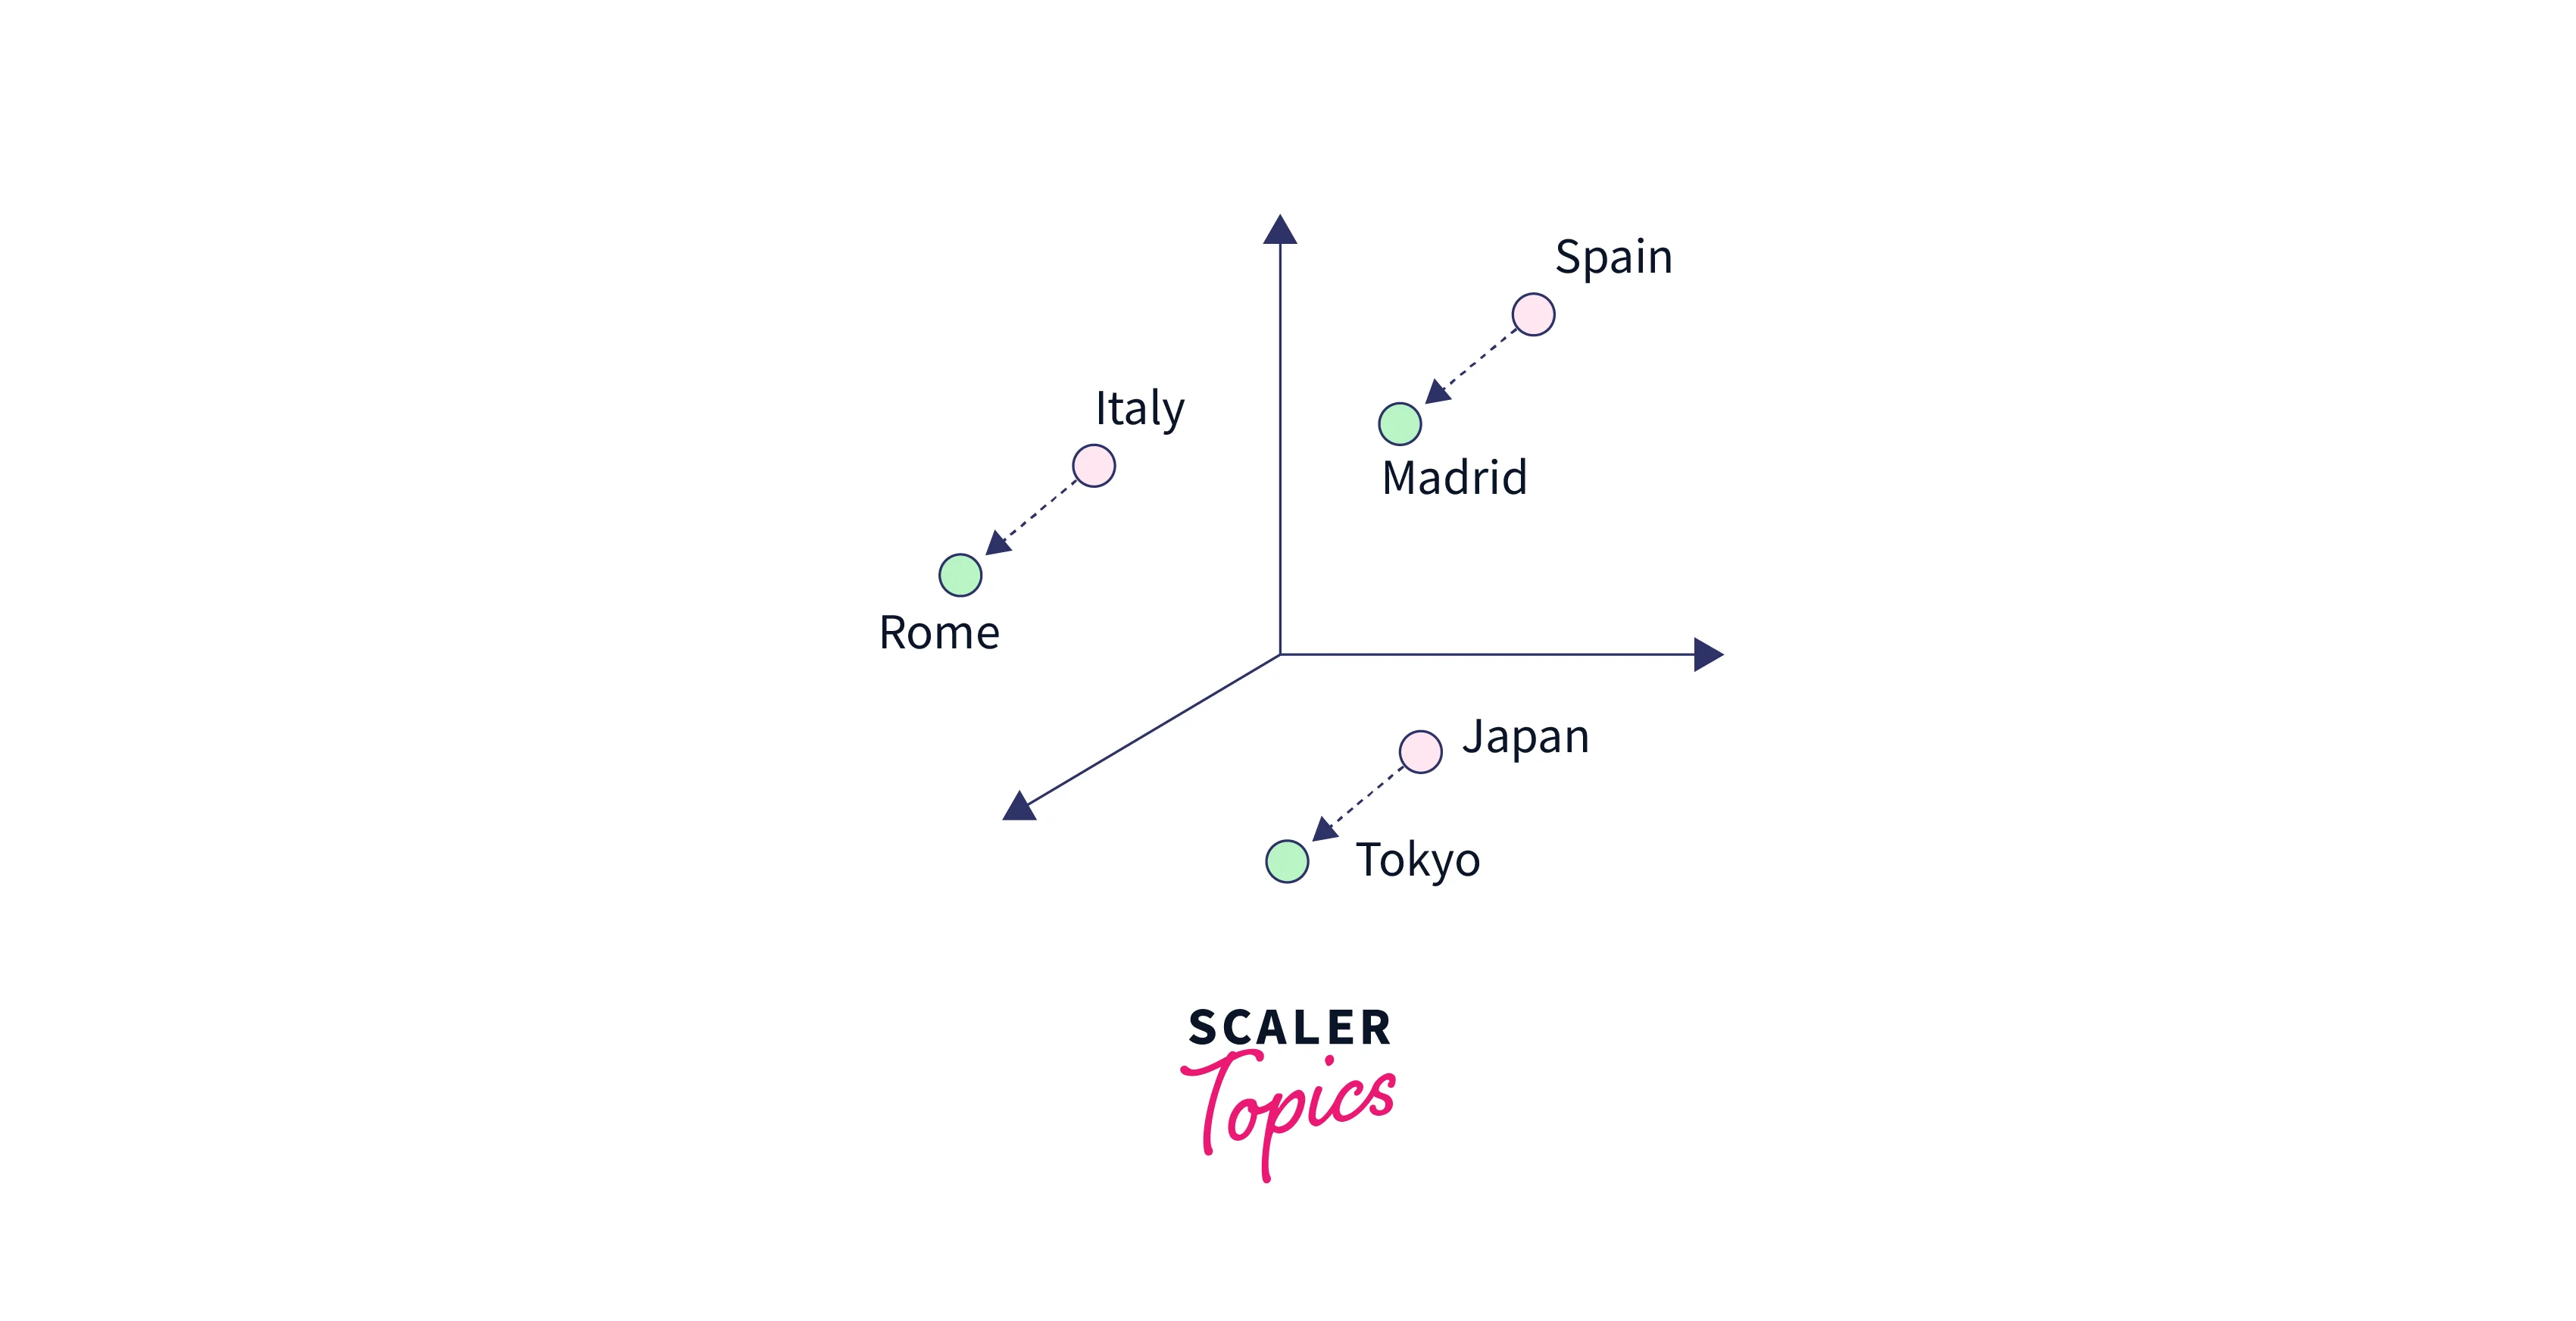 